# Salaries and Performance in the National Hockey League (NHL)

By looking at third league modeled on the North American system we can get a better understanding of the three variables we have used to explain win perecentage: salaries, lagged win percentage, and fixed effects.

We follow the same steps as we did for both those leagues.

In [1]:
# As usual, we begin by loading the packages we will need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Now we load the data

Hockey=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Sports Performance Analytics Specialization/Course 1 - Foundations of Sports Analytics: Data, Representation, and Models in Sports/work/Data/Week 5/NHL pay and performance.xlsx")

In [4]:
Hockey.describe()

,season,wpc,salaries
count,301.000000,301.000000,3.010000e+02
mean,2013.514950,0.500000,6.210188e+07
std,2.883969,0.091339,9.645558e+06
min,2009.000000,0.256098,2.972750e+07
25%,2011.000000,0.426829,5.640000e+07
50%,2014.000000,0.500000,6.409363e+07
75%,2016.000000,0.560976,6.955369e+07
max,2018.000000,0.750000,7.820526e+07


In [5]:
Hockey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Team      301 non-null    object 
 1   season    301 non-null    int64  
 2   wpc       301 non-null    float64
 3   salaries  301 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 9.5+ KB


We can see that we have 301 observations in total covering the seasons 2009 to 2018. This is somewhat more than we has in the NBA case, but much less than the MLB case. We can now look at the changes in total salary spending across the seasons:

In [6]:
Sumsal = Hockey.groupby(['season'])['salaries'].sum().reset_index().rename(columns={'salaries':'allsal'})
Sumsal

,season,allsal
0,2009,1541615281
1,2010,1552508107
2,2011,1625195685
3,2012,2083240145
4,2013,1875078749
5,2014,1870670657
6,2015,1936588513
7,2016,2010863335
8,2017,2044256803
9,2018,2152647770


Salary inflation has not been as dramatic in the NHL as in other leagues we have looked at, but they have still increased by more than one third in a decade, which is very unlikely to be caused by improving player quality on average. As with the other leagues, the main driver of increasing salaries has been increasing team revenues and the capacity of the players to bargain for higher wages.

As before, we use pd.merge() to add the aggregate salaries for each season to our original dataframe:

In [7]:
Hockey = pd.merge(Hockey, Sumsal, on=['season'], how='left')
display(Hockey)

,Team,season,wpc,salaries,allsal
0,Anaheim Mighty Ducks,2009,0.512195,49838000,1541615281
1,Atlanta Flames/Thrashers,2009,0.426829,34262500,1541615281
2,Boston Bruins,2009,0.646341,51535000,1541615281
3,Buffalo Sabres,2009,0.500000,52225700,1541615281
4,Calgary Flames,2009,0.560976,63100000,1541615281
...,...,...,...,...,...
296,Tampa Bay Lightning,2018,0.658537,73324166,2152647770
297,Toronto Arenas/St. Patricks/Maple Leafs,2018,0.597561,63934167,2152647770
298,Vancouver Canucks,2018,0.378049,72819166,2152647770
299,Washington Capitals,2018,0.597561,74965962,2152647770


We can now create a variable which we call 'relsal', which measures the share of a team's salary spend in the total spending of all teams in that season:

In [8]:
Hockey['relsal']= Hockey['salaries']/Hockey['allsal']

Before running a regression, it makes sense to look at the relationship between salaries and win percentage on a chart. To do this we use sns.reglot(). Since our argument is that higher relative salaries mean better players which in turns leads to more wins, we put relsal on the x axis and wpc on the y axis.

<Axes: xlabel='relsal', ylabel='wpc'>

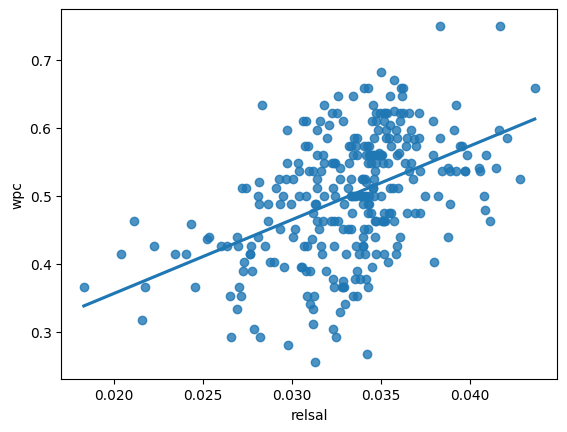

In [9]:
sns.regplot(x="relsal", y="wpc", data = Hockey, ci=False)

## Self Test

Re-run the regplot with smaller dots so that there is no overlap.

Note that the values of relsal on the x axis tend to vary between around 0.02 and 0.045, while wpc on the y axis tends to vary between around .3 and .7. The variation in relsal is much more like the NBA, while the variation in wpc is more like MLB.

As with all the other leagues it is clear from the data that there is a positive correlation between relsal and wpc, as shown by the regression line which regplot adds to the scatter diagram. We now run a regression using smf.ols() in order to derive the coefficients of the regression and other diagnostic statistics.

In [10]:
wpcsal1_lm = smf.ols(formula = 'wpc ~ relsal', data=Hockey).fit()
print(wpcsal1_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    wpc   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     84.33
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           7.17e-18
Time:                        08:20:49   Log-Likelihood:                 331.14
No. Observations:                 301   AIC:                            -658.3
Df Residuals:                     299   BIC:                            -650.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1404      0.039      3.560      0.0

For the NHL we find that the coefficient of relsal is quite similar to that of the NBA. In fact, the regression looks quite similar in terms of the intercept (this is the value of win percentage if relsal were zero) and the R-squared.

## Self Test

Create a subset of the data which includes only the 2018 season and run the regression of wpc on relsal. How do the results compare to the results above?

Let's see how the addition of the lagged dependent variable changes our relsal estimate.

In [11]:
# first we sort the values

Hockey.sort_values(by=['Team','season'], ascending=True)

,Team,season,wpc,salaries,allsal,relsal
0,Anaheim Mighty Ducks,2009,0.512195,49838000,1541615281,0.032328
30,Anaheim Mighty Ducks,2010,0.475610,55207500,1552508107,0.035560
60,Anaheim Mighty Ducks,2011,0.573171,53977500,1625195685,0.033213
90,Anaheim Mighty Ducks,2012,0.414634,74655277,2083240145,0.035836
120,Anaheim Mighty Ducks,2013,0.625000,67064166,1875078749,0.035766
...,...,...,...,...,...,...
179,Winnipeg Jets,2014,0.451220,63682588,1870670657,0.034043
209,Winnipeg Jets,2015,0.524390,63322574,1936588513,0.032698
239,Winnipeg Jets,2016,0.426829,52338400,2010863335,0.026028
269,Winnipeg Jets,2017,0.487805,64113622,2044256803,0.031363


In [12]:
# this will allow us to inspect all rows in the data

pd.set_option('display.max_rows', 400)
Hockey

,Team,season,wpc,salaries,allsal,relsal
0,Anaheim Mighty Ducks,2009,0.512195,49838000,1541615281,0.032328
1,Atlanta Flames/Thrashers,2009,0.426829,34262500,1541615281,0.022225
2,Boston Bruins,2009,0.646341,51535000,1541615281,0.033429
3,Buffalo Sabres,2009,0.500000,52225700,1541615281,0.033877
4,Calgary Flames,2009,0.560976,63100000,1541615281,0.040931
5,Carolina Hurricanes,2009,0.548780,49075000,1541615281,0.031833
6,Chicago Blackhawks,2009,0.560976,51548557,1541615281,0.033438
7,Colorado Rockies/Avalanche,2009,0.390244,51940000,1541615281,0.033692
8,Columbus Blue Jackets,2009,0.500000,52342500,1541615281,0.033953
9,Dallas Stars,2009,0.439024,55625000,1541615281,0.036082


In [13]:
# now we create the lagged dependend variable

Hockey['wpc_lag'] = Hockey.groupby('Team')['wpc'].shift(1)
Hockey

,Team,season,wpc,salaries,allsal,relsal,wpc_lag
0,Anaheim Mighty Ducks,2009,0.512195,49838000,1541615281,0.032328,NaN
1,Atlanta Flames/Thrashers,2009,0.426829,34262500,1541615281,0.022225,NaN
2,Boston Bruins,2009,0.646341,51535000,1541615281,0.033429,NaN
3,Buffalo Sabres,2009,0.500000,52225700,1541615281,0.033877,NaN
4,Calgary Flames,2009,0.560976,63100000,1541615281,0.040931,NaN
5,Carolina Hurricanes,2009,0.548780,49075000,1541615281,0.031833,NaN
6,Chicago Blackhawks,2009,0.560976,51548557,1541615281,0.033438,NaN
7,Colorado Rockies/Avalanche,2009,0.390244,51940000,1541615281,0.033692,NaN
8,Columbus Blue Jackets,2009,0.500000,52342500,1541615281,0.033953,NaN
9,Dallas Stars,2009,0.439024,55625000,1541615281,0.036082,NaN


We now run our regression again, but adding wpc_lag into the regression equation:

In [14]:
wpcsal2_lm = smf.ols(formula = 'wpc ~wpc_lag + relsal', data=Hockey).fit()
print(wpcsal2_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    wpc   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     53.13
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           3.87e-20
Time:                        08:21:43   Log-Likelihood:                 306.15
No. Observations:                 269   AIC:                            -606.3
Df Residuals:                     266   BIC:                            -595.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0716      0.043      1.656      0.0

Once again adding the lagged dependent variable is justified both in terms of the statistical significance of the variable and the addition to R-squared (whether adjusted or not). However, the impact on our main variable of interest, relsal, is relatively small. Its value has fallen from 10.8 to 8.4, which while it does suggest that there was some omitted variable bias, it is not as great as in the NBA case, while in the MLB case the coefficient of relsal was much smaller to begin with.

Let's now see what changes if we include fixed effects:

In [15]:
wpcsal3_lm = smf.ols(formula = 'wpc ~wpc_lag + relsal +C(Team)', data=Hockey).fit()
print(wpcsal3_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    wpc   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     5.715
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           4.55e-16
Time:                        08:22:11   Log-Likelihood:                 338.12
No. Observations:                 269   AIC:                            -610.2
Df Residuals:                     236   BIC:                            -491.6
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Here we find ten fixed effects that are statistically significant. The fixed effects add considerably to the R-squared of the regression, and only marginally reduce the value of relsal. However, the most striking impact of the fixed effects is to reduce the value of of the lagged dependent variable to the point where it is statistically insignificant. This is in contrast to what we found in all three of the other other leagues. Because it is statistically insignificant in this version, and since we want to keep the fixed effects, we can drop the lagged dependent variable, which we do in this regression:  

In [16]:
wpcsal4_lm = smf.ols(formula = "wpc ~  relsal +C(Team)", data=Hockey).fit()
print(wpcsal4_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    wpc   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     6.366
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           7.26e-19
Time:                        08:23:22   Log-Likelihood:                 378.83
No. Observations:                 301   AIC:                            -691.7
Df Residuals:                     268   BIC:                            -569.3
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

This model has a very simple interpretation: wpc = 0.256 + 8.76 x relsal + fixed effects. If we ignore fixed effects, we can identify the expected win percentage for low, average and high relative spending:

In [17]:
print(0.256 + 8.76*0.02)
print(0.256 + 8.76*0.0325)
print(0.256 + 8.76*0.045)

0.4312
0.5407
0.6502


## Self Test

Based on the fixed effects regression, calculate the win percentage of:

(a) The Calgary Flames assuming the value of relsal for the team is 0.03
(b) The Edmonton Oilers assuming the value of relsal for the team is 0.04
(c) The Montreal Canadiens assuming the value of relsal for the team is 0.05

Looking at this, we can see that the numbers are slightly skewed- the performance levels are higher than one might expect at each level, and this most likely reflects the impacts of the fixed effects. It's clear that most of the fixed effects are negative, and this would bring down teams to a lower level of performance. It suggests that those teams that are able to dominate, are capable of doing so (or at least were capable of doing so during this era) because of factors other than wage spending.

# Conclusion

This week we have looked at four different leagues and used salary data to assess the impact of wage spending on team performance. In every case we found it had a significant impact, but that impact varied depending on the league. The league system also mattered, as we saw when contrasting the cases of the EPL with the NBA, MLB and NHL.

We also introduced two issues which should always be considered when running regressions: omitted variable bias and heterogeneity.

Finally, we should mention one issue which arises in the context of this type of exercise. The data we study here is "observational", meaning that we collect the data based on what actually happened, during events over which we had no control. This raises the question, "How would outcomes have been different if some particular variable had had a different value?" The regression coefficients produced some answers for us, but how can we be sure that there was not some other factor which we have omitted, which was what really mattered? We can't be sure.

Scientists in laboratories typically don't have this problem - they use "experimental data" which they create in a controlled environment, so that they can control all observable factors. You can use that kind of data to measure the aerobic capacity of an athlete but, since you can't directly control the game, you can never use it to analyze game outcomes.

Some experimental scientists would go so far as to say that we can infer nothing from observational data. This is the logic of a phrase you may have encountered: "correlation is not causation". We have observed correlations in the data using regression analysis, but that does not prove that the links were causal (you could go so far as to argue that win percentage causes salaries to increase, and not vice versa).

We think that is too pessimistic a view. Observational data is certainly more challenging to work with, but it is possible for us to gain insight into the underlying relationships through careful study. It is important to be aware of the pitfalls, and it is important to focus on the logical coherence of the analysis rather than just running regressions. Another way to say this is that one should always have in mind a theory that one is trying to test, and be willing to discard that theory if the data renders it untenable. With careful thought and attention to details, it is possible to generate results which can enhance our understanding.



